In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor

# Capstone Project - Function 3

## Function 3 - Drug Discovery Problem

**Problem Description** In this example, you are doing drug discovery! You can select three compounds to create a drug, and receive a measurement of the people’s adverse reaction to the drug. You want to make this as close as possible to zero. (hint: one of the variables may not cause any effects on the person).

**Acquisition Function found to be the most efficient over time:** Probability of Improvement

**Kernel Idea (evolved over time from simple default kernel usage to parametrized kernel based on inputs/outputs and function context):**
In the context of a drug discovery problem where the goal is to minimize adverse reactions, a Gaussian Process Regression (GPR) model can be particularly useful. For such a problem, we might consider using a combination of kernels that can capture different aspects of the data. A common choice is the Matérn kernel, which is flexible and can model functions that are not infinitely differentiable, making it suitable for real-world applications. The Matérn kernel's smoothness parameter, allows to control the function's smoothness, which is beneficial when dealing with real-world, noisy data1.
Additionally, incorporating a WhiteKernel can help account for the noise in the measurements of the adverse reactions. 
For inputs that are in the range of 0 to 1, we might want to start with a smaller length_scale parameter in our kernel to allow the model to capture the finer variations in the input space. Since the output needs to be as close to 0 as possible, we might also want to ensure that the noise_level parameter in the WhiteKernel is set appropriately to reflect the expected scale of the noise in the outputs.

### 1.Loading the available data:
Here we first load the available datasets (1 and 2), then we add our weekly inputs/outputs to the dataset. 

In [10]:
# Loading the baseline data
X = np.load('initial_data/function_3/initial_inputs.npy')
Y = np.load('initial_data/function_3/initial_outputs.npy')
X2 = np.load('initial_data2/function_3/initial_inputs.npy')
Y2 = np.load('initial_data2/function_3/initial_outputs.npy')

X = np.concatenate((X,X2), dtype = float)
Y = np.concatenate((Y,Y2), dtype = float)

# Precision notation
np.set_printoptions(suppress=False)

# Adding knwon inputs/outputs from previous weeks
Xn = np.array([
    [0.111111, 0.111111, 0.111111],
    [0.287878, 0.293636, 0.384848],
    [0.992131, 0.78, 0.5],
    [0.492581, 0.611593, 0.340176],
    [0.720404, 0.60707,  0.435858],
    [0.992121, 0.78,     0.499494],
    [0.992121, 0.78,     0.499494],
    [0.991818, 0.779696, 0.499494],
    [0.75, 0.61, 0.44],
    [0.73265,  0.611927, 0.438554],
    [0.96, 0.75, 0.45],
    [0.99216,  0.779949, 0.499748],
    [0.991758, 0.780552, 0.499748],
    [0.991935, 0.780322, 0.5     ],
    [0.670202, 0.688889, 0.571717],
    [0.65,     0.69697,  0.585859],
    [0.84,     0.609357, 0.468675],
    [0.73,     0.595702, 0.452208],
    [0.730101, 0.572342, 0.455261],
    [0.732211, 0.59763,  0.451084]
])
X = np.concatenate((X,Xn), dtype = float)

Yn = np.array(
[
    -0.109975,
    -0.0303172346,
    -0.02983464525,
    -0.03377847951,
    -0.002625783576,
    -0.015797272,
    -0.02463770059,
    -0.01208667417,
    -0.001389751495,
    -0.001558892201,
    -0.008509286085,
    -0.0219260753,
    -0.01244809153,
    -0.02079718418,
    -0.04511428629,
    -0.04300127274,
    -0.03991021071,
    -0.002020785936,
    -0.01622322617,
    -0.001494640057
])
Y = np.concatenate((Y,Yn), dtype = float)

In [11]:
print("X:\n")
print(X)
print("\n")
print("Y:\n")
print(Y)

X:

[[0.17152521 0.34391687 0.2487372 ]
 [0.24211446 0.64407427 0.27243281]
 [0.53490572 0.39850092 0.17338873]
 [0.49258141 0.61159319 0.34017639]
 [0.13462167 0.21991724 0.45820622]
 [0.34552327 0.94135983 0.26936348]
 [0.15183663 0.43999062 0.99088187]
 [0.64550284 0.39714294 0.91977134]
 [0.74691195 0.28419631 0.22629985]
 [0.17047699 0.6970324  0.14916943]
 [0.22054934 0.29782524 0.34355534]
 [0.66601366 0.67198515 0.2462953 ]
 [0.04680895 0.23136024 0.77061759]
 [0.60009728 0.72513573 0.06608864]
 [0.96599485 0.86111969 0.56682913]
 [0.16569979 0.25685582 0.65469   ]
 [0.65099632 0.42417272 0.52674437]
 [0.10601263 0.24333177 0.65025654]
 [0.35216426 0.10580766 0.06546785]
 [0.829086   0.4393692  0.20713429]
 [0.80489315 0.31206954 0.24371441]
 [0.46204056 0.12939599 0.83858636]
 [0.82217052 0.46650685 0.54929183]
 [0.98514841 0.72088289 0.77643975]
 [0.18674264 0.60674065 0.66958022]
 [0.28810255 0.70297378 0.89849626]
 [0.08742747 0.26673553 0.30128017]
 [0.87436053 0.86753817 

In [12]:
# We look at and store the max output we obtained until now, and its related input values.
y_max = np.max(Y)
print("Max output until now: ", y_max, "which corresponds to input: ", X[np.where(Y == y_max)][0])

Max output until now:  -0.001389751495 which corresponds to input:  [0.75 0.61 0.44]


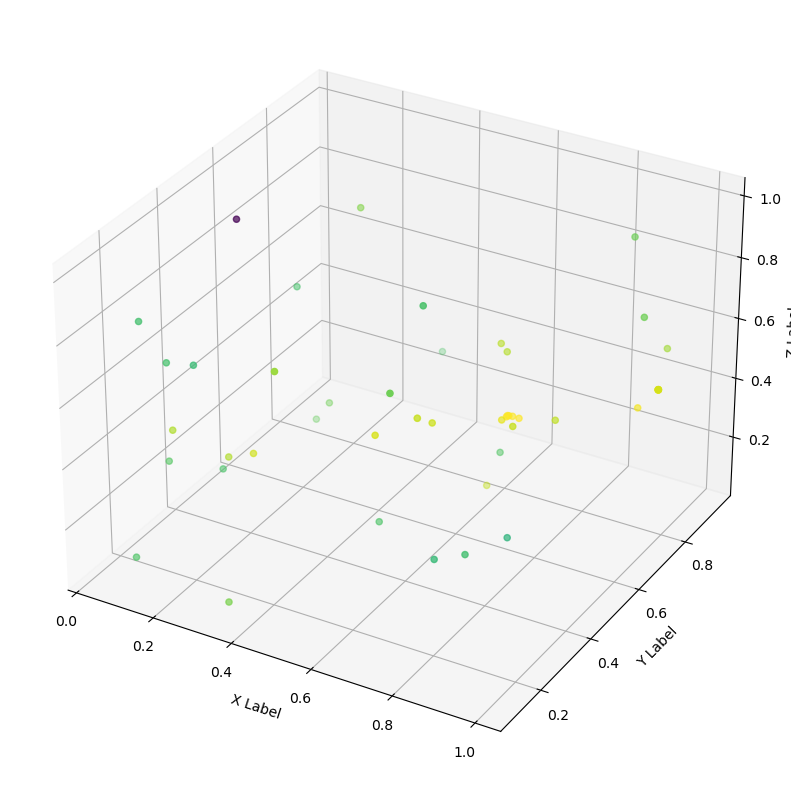

In [13]:
# Plot the two dimensions for visibility, as long as it's less than 4 dimensions, it can help.
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Assuming X is a 2D array where each row is a sample and each column is a feature
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=Y)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

### 2. Build a Bayesian Model
Here we will build the bayesian model using Gaussian Process Regression (GPR). This method was explored in the course and is also the method recommended by the litterature.
GPR is widely used in blackbox machine learning models due to its representation flexibility and inherent capability to quantify uncertainty over predictions.

Advantages:
- Flexibility: GPR is a non-parametric method, meaning it makes fewer prior assumptions about the form of the function that maps inputs to outputs.
- Uncertainty Quantification: One of the key advantages of GPR is its ability to provide a measure of uncertainty along with predictions.
- Kernel Functions: GPR uses kernel functions to define the similarity between data points. This allows the model to capture complex patterns and structures in the data. We played with kernel functions during the full capstone project to find the best candidate.
- Prior Knowledge Incorporation: GPR allows for the incorporation of prior knowledge through the use of different kernel functions.
- Surrogate Modeling: GPR is often used as a surrogate model in optimization problems, where the goal is to find the best parameters of a blackbox function that is expensive to evaluate. 

Inconvenients:
- Computation resources: It can be computationally expensive for large datasets, and choosing the right kernel function can be challenging.

#### Approach for Kernel and parameters

In the context of a drug discovery problem where the goal is to minimize adverse reactions, a Gaussian Process Regression (GPR) model can be particularly useful. For such a problem, we might consider using a combination of kernels that can capture different aspects of the data. A common choice is the Matérn kernel, which is flexible and can model functions that are not infinitely differentiable, making it suitable for real-world applications. The Matérn kernel's smoothness parameter, allows to control the function's smoothness, which is beneficial when dealing with real-world, noisy data1.
Additionally, incorporating a WhiteKernel can help account for the noise in the measurements of the adverse reactions. 
For inputs that are in the range of 0 to 1, we might want to start with a smaller length_scale parameter in our kernel to allow the model to capture the finer variations in the input space. Since the output needs to be as close to 0 as possible, we might also want to ensure that the noise_level parameter in the WhiteKernel is set appropriately to reflect the expected scale of the noise in the outputs.

In [14]:
# Create a Gaussian Process Regressor with the specified kernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel as W

# Adjust the kernel parameters to suit the scale of the problem
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=0.1, length_scale_bounds=(1e-3, 1e1), nu=2.5) + W(noise_level=0.1, noise_level_bounds=(1e-10, 1e-1))

# Create the Gaussian Process Regressor model
gpr = GaussianProcessRegressor(kernel=kernel, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=11)

gpr.fit(X, Y)

GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=0.1, nu=2.5) + WhiteKernel(noise_level=0.1),
                         n_restarts_optimizer=11)

### 3. Acquisition Function 1 - Upper Confidence Bound

Upper-Confidence Bound action selection uses uncertainty in the action-value estimates for balancing exploration and exploitation. Since there is inherent uncertainty in the accuracy of the action-value estimates when we use a sampled set of rewards thus UCB uses uncertainty in the estimates to drive exploration.
We started the captstone with high exploration (ucb = mean + 1.96 * standard_deviation) but ended up with more exploitation (1.96 -> 1.12) when inputs were converging, still more exploration than Function 1 and 2 due to current outputs found.

In [15]:
# To optimize the acquisition function, we will simply use gridsearch over a space of 10000 gridpoints
# We use the local maximum from the input we have
x1 = np.linspace(0.73, 0.80, 250)
x2 = np.linspace(0.57, 0.65, 250)
x3 = np.linspace(0.40, 0.48, 250)

X_grid = []
for i in range(len(x1)):
    for j in range(len(x2)):
        for k in range(len(x3)):
            X_grid.append([x1[i], x2[j], x3[k]])
        
X_grid = np.array(X_grid)
mean, std = gpr.predict(X_grid, return_std = True)

ucb1 = mean + 0.86 * std

idx_max = np.argmax(ucb1)
UB_NextQuery = X_grid[idx_max]
print("UCB - Next Query - Idea 1: ", UB_NextQuery)

UCB - Next Query - Idea 1:  [0.73       0.65       0.44497992]


### 4. Acquisition Function 2 - Probability of Improvement

The Probability of Improvement (PI) is an acquisition function which chooses the next query point as the one which has the highest probability of improvement over the current best observation. 
In other words, for each candidate point x, it assigns the probability of f(x) being larger than our current best f(x*). 
This helps balance the trade-off between exploration (probing areas of the search space where the outcome is uncertain) and exploitation (probing areas where the model predicts a good outcome).

In [16]:
from scipy.stats import norm

# Compute PI values for candidate points
def compute_pi(x):
    mu, sigma = gpr.predict(X_grid, return_std = True)
    z = (mu - y_max) / sigma
    pi = norm.cdf(z)
    return pi

pi_values = compute_pi(X_grid)

# Choose the next point with maximum PI value
next_idx = np.argmax(pi_values)
PI_NextQuery = X_grid[next_idx]

print("PI - Next Query - Idea 1: ", PI_NextQuery)

PI - Next Query - Idea 1:  [0.73       0.63586345 0.44433735]


### 5. Acquisition Function 3 - Thompson Sampling

Thompson Sampling is a heuristic for decision-making problems that balances exploration and exploitation. It works by sampling parameters from the posterior distribution, then choosing the action that maximizes the expected reward.

In [ ]:
# To optimize the acquisition function, we will simply use gridsearch over a space of 1000000 gridpoints
# We use the local maximum from the input we have
x1 = np.linspace(0.73, 0.80, 150)
x2 = np.linspace(0.57, 0.65, 150)
x3 = np.linspace(0.40, 0.48, 150)

X_grid = []
for i in range(len(x1)):
    for j in range(len(x2)):
        for k in range(len(x3)):
            X_grid.append([x1[i], x2[j], x3[k]])
            
# Compute Thompson Sampling values for candidate points
def compute_thompson(x):
    mu, sigma = gpr.predict([x], return_std=True)
    sample = np.random.normal(mu, sigma)
    return sample

thompson_values = [compute_thompson(x) for x in X_grid]

# Choose the next point with maximum Thompson Sampling value
next_idx = np.argmax(thompson_values)
TS_NextQuery = X_grid[next_idx]

print("Thompson Sampling - Next Query: ", TS_NextQuery)

### 6. Acquisition Function 4 - Bayesian Expected Losses

Bayesian Expected Loss is the expected value of a loss function with respect to the posterior distribution. It's used in decision-making to compare actions, where the preferred action is the one for which the posterior expected loss is smaller. This concept is central to Bayesian decision theory.

In [ ]:
# Compute the expected loss for candidate points
def compute_expected_loss(x):
    mu, sigma = gpr.predict([x], return_std=True)
    z = (mu - y_max) / sigma
    expected_loss = (mu - y_max) * norm.cdf(z) + sigma * norm.pdf(z)
    return expected_loss

# We re-use X_grid due to computational needs
expected_loss_values = [compute_expected_loss(x) for x in X_grid]

# Choose the next point with minimum expected loss
next_idx = np.argmin(expected_loss_values)
BL_NextQuery = X_grid[next_idx]

print("Bayesian Expected Loss - Next Query: ", BL_NextQuery)

### 7. Acquisition Function 5 - Expected Improvement

Expected Improvement (EI) is an acquisition function which selects the next point to sample by maximizing the expected improvement over the current best estimate. Unlike Probability of Improvement, EI considers not just the probability, but also the magnitude of the potential improvement.

In [ ]:
# Compute Expected Improvement for candidate points
def compute_expected_improvement(x):
    mu, sigma = gpr.predict([x], return_std=True)
    f_best = np.max(Y)
    z = (mu - f_best) / sigma
    ei = (mu - f_best) * norm.cdf(z) + sigma * norm.pdf(z)
    return ei

ei_values = [compute_expected_improvement(x) for x in X_grid]

# Choose the next point with maximum EI value
next_idx = np.argmax(ei_values)
EI_NextQuery = X_grid[next_idx]

print("Expected Improvement - Next Query: ", EI_NextQuery)

## Predict Output for next query: select next inputs
Based on the next queries found using our set of acquisition functions, we use the prediction of the model to see which prediction would maximizse the output (potentially) and send the top 1 or 2 each week to the form. 

In [ ]:
formatted_UCB = "{}{:.6f}-{:.6f}-{:.6f} -> {}".format("UCB: ",UB_NextQuery[0],UB_NextQuery[1],UB_NextQuery[2], gpr.predict([UB_NextQuery]))
formatted_PI = "{}{:.6f}-{:.6f}-{:.6f} -> {}".format("PI: ",PI_NextQuery[0],PI_NextQuery[1],PI_NextQuery[2], gpr.predict([PI_NextQuery]))
formatted_TS = "{}{:.6f}-{:.6f}-{:.6f} -> {}".format("TS: ",TS_NextQuery[0],TS_NextQuery[1],TS_NextQuery[2], gpr.predict([TS_NextQuery]))
formatted_BL = "{}{:.6f}-{:.6f}-{:.6f} -> {}".format("BL: ",BL_NextQuery[0],BL_NextQuery[1],BL_NextQuery[2], gpr.predict([BL_NextQuery]))
formatted_EI = "{}{:.6f}-{:.6f}-{:.6f} -> {}".format("EI: ",EI_NextQuery[0],EI_NextQuery[1],EI_NextQuery[2], gpr.predict([EI_NextQuery]))

print(formatted_UCB)
print(formatted_PI)
print(formatted_TS)
print(formatted_BL)
print(formatted_EI)